# Fundamentals of Machine Learning - Exercise 7

Johannes Kammerer, Zhao Sun, Tong Yu

In [1]:
# import
import numpy as np
from scipy.sparse import coo_matrix, csr_matrix, diags, vstack, hstack
from scipy.sparse.linalg import lsqr
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.linalg import lstsq
import sklearn
from sklearn.datasets import load_digits
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

## 4 Fitting Circles

In [3]:
data = np.load("circles.npy")

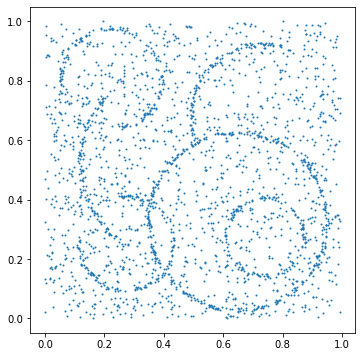

In [4]:
fig = plt.figure(figsize=(6,6))
plt.scatter(x = data[:,0], y = data[:,1], s=1)
plt.gca().set_aspect('equal', 'box')
plt.show()

Observation: Visually, we see 2 full circles, 2 almost full circles and 2 circle segments.

<span style ="color: green; font-weight: bold;  "> COMMENTS: We visualized the original figure of the circles, and saw the circles and circle segments. </span>

### 4.1 RANSAC (6 Points)

Circle equation adjusted from <a href='https://stackoverflow.com/questions/28910718/give-3-points-and-a-plot-circle'>here</a>.

In [5]:
def fitC(data, N, eps, NC):
    circles = np.zeros((NC, 3))
    inliers = []
    for nc in range(NC):
        Ninl = 0
        num = data.shape[0]
        for i in range(N):
            rndp = np.random.choice(num, 3, replace = False)
            ctr0, ctr1, rad = circEq(data[rndp,0], data[rndp,1])
            radAll = np.sqrt((data[:,0]-ctr0)**2 + (data[:,1]-ctr1)**2)
            inlListNew = (abs(radAll-rad) < eps)
            NinlNew = np.count_nonzero(inlListNew)
            if NinlNew > Ninl:
                Ninl = NinlNew
                crcl = ctr0, ctr1, rad
                inlData = data[inlListNew,:]
                inlList = inlListNew
        circles[nc,:] = crcl
        data = data[np.invert(inlList)]
        inliers.append(inlData)
    return circles, inliers
    
def circEq(x, y):
    assert len(x) == len(y)
    a, b, c = [complex(x[i], y[i]) for i in range(len(x))]
    w = c-a
    w /= b-a
    com = (a-b)*(w-abs(w)**2)/2j/w.imag-a
    ctr0, ctr1, rad = (-com.real, -com.imag, abs(com+a))
    return ctr0, ctr1, rad

<span style ="color: green; font-weight: bold;  "> COMMENTS: When calculating the circle through 3 chosen points, unlike the given solution, which creates a linear system of 2 equations and then solves them, we took <a href='https://stackoverflow.com/questions/28910718/give-3-points-and-a-plot-circle'> this method </a> as reference, and got our circle equation from 3 chosen points. Besides, our implement of RANSAC method is essentially same with the given solution. </span>

For $\gamma$ = inlier rate, $k=3$ (a circle in 2D) and the hyperparameter $\alpha$, the minimum number of iterations $N$ is $N=\frac{log(1-\alpha)}{log(1-\gamma^k)}$.

Let us estimate $\gamma=0.1$, then for $\alpha=0.99$, one gets $N=4603$. We also compared this with $N=169$ (for $\gamma=0.3$) and found that the algorithm improves significantly with the larger value.

<span style ="color: green; font-weight: bold;  "> COMMENTS: We discussed the minimum number of iterations, and the decided to use the larger iteration number N = 4600, which is not included in the given solution.</span>

In [6]:
NC = 6
epsilons = [0.005, 0.01, 0.05]
np.random.seed(30)
crcls4600 = [fitC(data, 4600, eps, NC)[0] for eps in epsilons]

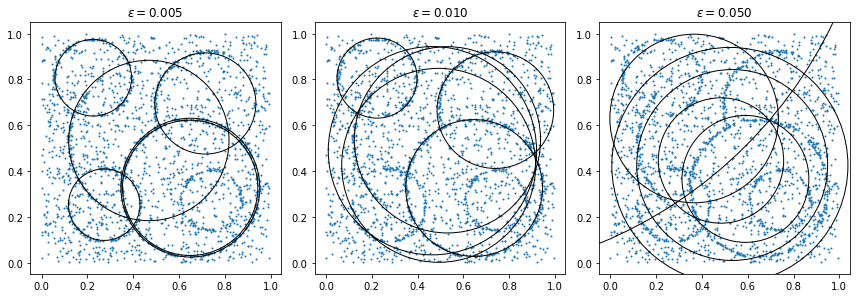

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(12,8), tight_layout=True)
for i in range(3):
    axes[i%3].scatter(data[:,0], data[:,1], s=1)
    axes[i%3].set_aspect('equal', 'box')
    for nc in range(NC):
        axes[i%3].add_artist(plt.Circle((crcls4600[i][nc,0], crcls4600[i][nc,1]), crcls4600[i][nc,2], fill=False))
    axes[i%3].set_title('$\epsilon=%.3f$' %epsilons[i])
plt.show()

Observation: For the small $\epsilon=0.005$, the points of the lower right large circle have been distributed between two fitted circles because the spread of the points was larger than $\epsilon$. For $\epsilon=0.01$, four circles or circle segments were detected and fitted. For the large $\epsilon=0.05$, the data are collected by roughly concentric circles because with such a coarse resolution the algorithm did not "see" (i.e. detect) the circles.

<span style ="color: green; font-weight: bold;  "> COMMENTS: We also discussed what is optimal values of $\epsilon$ for plotting the circles, which is not covered in the sample solution. We found the data fitting best when $\epsilon = 0.005$, and used this value in the following task. Besides, we find the sample solution's result figure pretty clear by distinguishing the outliers and inliers with red and green colors. </span>

### 4.2 Algebraic Distance (4 Points)

We use the transformations from the lecture notes:

$\tilde{X}=[x_1,x_2,1]$ 

$\tilde{Y}=x_1^2+x_2^2$ 

and the back transformation

$\hat{c}_1=\hat{\tilde{\beta}}_1/2$, $\hat{c_2}=\hat{\tilde{\beta}}_2/2$, $r=(\hat{\tilde{\beta}}_3^2+\hat{c}_1^2+\hat{c}_2^2)^{1/2}$

In [28]:
NC = 6
epsilon = 0.005
np.random.seed(30)
res = fitC(data, 4600, epsilon, NC)
crcls, inliers = res

In [29]:
def algebC(inliers):
    NC = len(inliers)
    circles = np.zeros((NC,3))
    for nc in range(NC):
        inlData = inliers[nc]
        x1, x2 = inlData[:,0], inlData[:,1]
        xtil = np.dstack([x1,x2,np.ones(len(x1))])[0]
        ytil = x1**2+x2**2
        # solve beta_hat = argmin sum (ytil - xtil*beta)**2
        btil = lstsq(xtil, ytil)[0]
        b1, b2, b3 = btil
        c1 = b1/2
        c2 = b2/2
        r = np.sqrt(b3**2+c1**2+c2**2)
        circles[nc,:] = c1, c2, r
    return circles

<span style ="color: green; font-weight: bold;  "> COMMENTS: We used  least-squares method by hand to refine the fitting, while the solution uses "least_squares" from "scipy.optimize" to solve easily. </span>

In [30]:
algCrcls = algebC(inliers)

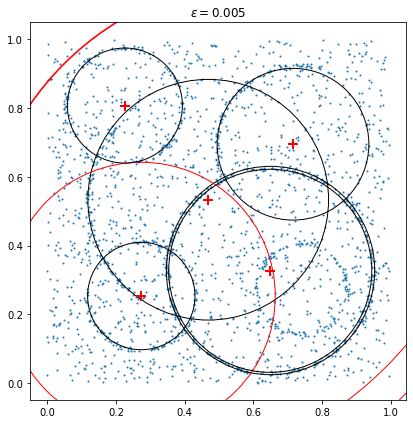

In [31]:
fig, axes = plt.subplots(1, 1, figsize=(6,6), tight_layout=True)
axes.scatter(data[:,0], data[:,1], s=1)
axes.set_aspect('equal', 'box')
for nc in range(NC):
    axes.add_artist(plt.Circle((crcls4600[0][nc,0], crcls4600[0][nc,1]), crcls4600[0][nc,2], fill=False))
    axes.add_artist(plt.Circle((algCrcls[nc,0], algCrcls[nc,1]), algCrcls[nc,2], color='red', fill=False))
axes.plot(algCrcls[:,0], algCrcls[:,1], '+', mew=2, ms=10, c='red')
plt.title('$\epsilon=%.3f$' %epsilon)
plt.show()

Observation: using the algebraic methods, the circles have the right centers (red crosses), but have far too large radii.